# Rule Trends - by Location
Andrew Reichel



List:
- MBA All Trans

TODO:
- MBA All Returns

### Configure libraries and load dataset (previously aggregated into csv from discrete xlsx)

In [1]:
import pandas as pd
import sys, os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

''' setup paths '''
data_dir = '../data/'

for doc in os.listdir(data_dir):
    if doc.endswith('csv'):
        df_0911 = pd.read_csv(os.path.join(data_dir,doc),index_col=0)
df_0911.head()

In [95]:
df_0911.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom

### Establish frunctions to prep data and mine rules

In [4]:
def cleanup_df(df_in):
    ''' clean up DESCRIPTION col of df_in to:
            1. remove spaces
            2. drop rows w/o invoice numbers
            3. drop postage row
            4. remove returned transactions (C) '''
    # drop extra spaces
    df_in.loc[:,'Description'] = df_in.loc[:,'Description'].str.strip()
    # drop rows w/o invoice number
    #df_in.dropna(axis=0, subset=['Invoice'], inplace=True)
    df_in.loc[:,'Invoice'] = df_in.loc[:,'Invoice'].astype(str)
    # drop postage row
    #df_in = df_in.Description.drop('POSTAGE', axis = 0)
    # drop Invoice == 'C' rows
    df_in = df_in[~df_in.loc[:,'Invoice'].str.contains('C')]
    
    return df_in

def encode_purch(item):
    ''' set all instances of purchase to 1, else == 0
        drop postage column '''
    if item >= 1:
        return 1
    else:
        return 0

def make_basket(df_in):
    ''' setup basket for MBA 
            1. One Hot Encode transactions 
            2. '''
    df_cleaned = cleanup_df(df_in)
    basket = (df_cleaned.groupby(['Invoice','Description'])['Quantity']
              .sum().unstack().reset_index().fillna(0).set_index('Invoice'))
    
    basket = basket.applymap(encode_purch)
    #print basket.POSTAGE
    if 'POSTAGE' in basket.columns:
        basket = basket.drop('POSTAGE', axis = 1)
    return basket

def mine_rules(country, min_supp = 'NA', verbose = False):  
    ''' function to extract rules or perform min_supp sensitivity test if no
        min_supp is provided '''
    # find orders by country
    df_country = df_0911[df_0911.Country == country]
    
    # make baskets
    baskets = make_basket(df_country)
    print "len of basket: ",len(baskets)
    
    ''' if min_supp not given, run sensitivity test on minsupp, else find
        all association rules '''
    if min_supp == 'NA':
        items = {}
        for min_sup in np.linspace(0.41, 0.02, 35):
            frq_itms = apriori(baskets, min_support=min_sup, use_colnames=True)
            items[min_sup] = len(frq_itms)
            if verbose == True:
                print "Considering Min_Supp: {}: {}".format(min_sup, len(frq_itms))
        freq_items = pd.DataFrame.from_dict(items, orient='index')
        return items
    else:
        freq_items = apriori(baskets, min_support=min_supp, use_colnames=True)
        rules = association_rules(freq_items, metric='confidence', min_threshold=0.35)
        return rules


### Test on USA Orders 

In [96]:
df_USorders = df_0911[df_0911.Country == 'USA']
print "US Orders: ", len(df_USorders.Invoice.unique())
df_USorders.head()

US Orders:  25


Invoice StockCode                 Description  Quantity  \
126    489444      POST                     POSTAGE         1   
51589  494110     21268    VINTAGE BLUE TINSEL REEL        24   
51590  494110     21412    VINTAGE GOLD TINSEL REEL        11   
51591  494110     22083  PAPER CHAIN KIT RETRO SPOT         6   
51592  494110     22084      PAPER CHAIN KIT EMPIRE         6   

               InvoiceDate   Price  Customer ID Country  
126    2009-12-01 09:55:00  141.00      12636.0     USA  
51589  2010-01-11 12:29:00    2.10      12549.0     USA  
51590  2010-01-11 12:29:00    0.42      12549.0     USA  
51591  2010-01-11 12:29:00    2.95      12549.0     USA  
51592  2010-01-11 12:29:00    2.95      12549.0     USA

In [97]:
print make_basket(df_USorders).shape
baskets = make_basket(df_USorders)
baskets.head()

(20, 303)


Description  12 PENCILS SMALL TUBE RED RETROSPOT  \
Invoice                                            
489444                                         0   
494110                                         0   
494113                                         0   
494234                                         0   
494891                                         0   

Description  3 RAFFIA RIBBONS 50'S CHRISTMAS  \
Invoice                                        
489444                                     0   
494110                                     0   
494113                                     0   
494234                                     0   
494891                                     0   

Description  3 TRADITIONAl BISCUIT CUTTERS  SET  36 DOILIES DOLLY GIRL  \
Invoice                                                                  
489444                                        0                      0   
494110                                        0                      0   
494113                                        0                      0   
494234                                        0                      0   
494891                                        0                      0   

Description  36 DOILIES SPACEBOY DESIGN  5 HOOK HANGER MAGIC TOADSTOOL  \
Invoice                                                                  
489444                                0                              0   
494110                                0                              0   
494113                                0                              0   
494234                                0                              0   
494891                                0                              0   

Description  5 HOOK HANGER RED MAGIC TOADSTOOL  6 GIFT TAGS 50'S CHRISTMAS  \
Invoice                                                                      
489444                                       0                           0   
494110                                       0                           0   
494113                                       0                           0   
494234                                       0                           0   
494891                                       0                           0   

Description  6 GIFT TAGS VINTAGE CHRISTMAS  60 CAKE CASES DOLLY GIRL DESIGN  \
Invoice                                                                       
489444                                   0                                0   
494110                                   0                                0   
494113                                   0                                0   
494234                                   0                                0   
494891                                   0                                0   

Description  ...  VINTAGE UNION JACK BUNTING  VINTAGE UNION JACK SHOPPING BAG  \
Invoice      ...                                                                
489444       ...                           0                                0   
494110       ...                           0                                0   
494113       ...                           0                                0   
494234       ...                           0                                0   
494891       ...                           1                                0   

Description  WOOD STAMP SET BEST WISHES  WOODLAND DESIGN  COTTON TOTE BAG  \
Invoice                                                                     
489444                                0                                 0   
494110                                0                                 0   
494113                                0                                 0   
494234                                0                                 0   
494891                                1                                 1   

Description  WRAP CHRISTMAS VILLAGE  WRAP COWBOYS  

(0.42, 0.04)

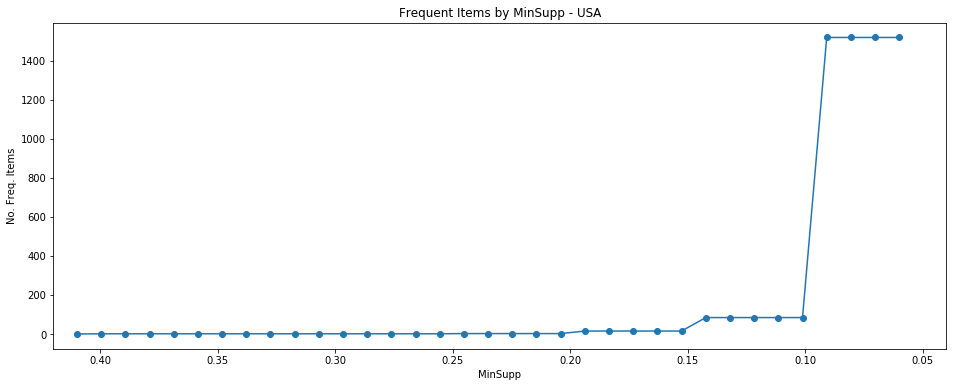

In [98]:
''' find minsupp sensitivity '''
items = {}
for min_sup in np.linspace(0.41, 0.06, 35):
    #print "Considering Min_Supp: ", min_sup
    frq_itms = apriori(baskets, min_support=min_sup, use_colnames=True)
    items[min_sup] = len(frq_itms)

freq_items = pd.DataFrame.from_dict(items, orient='index')

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
ax.set_title('Frequent Items by MinSupp - USA')
ax.set_xlabel('MinSupp')
ax.set_ylabel('No. Freq. Items')
ax.scatter(freq_items.index, freq_items.iloc[:,0])
ax.plot(freq_items.sort_index())
ax.set_xlim(0.42, 0.04)

### Find ideal min_supp, by country

In [119]:
print "Unique Countries in Data: {}".format(len(df_0911.Country.unique()))

country_ords = {}
for country in df_0911.Country.unique():
    tmp = df_0911[df_0911.Country == country]
    #print country, len(tmp)
    country_ords[country] = len(tmp.Invoice.unique())

df_ords_Country = pd.DataFrame.from_dict(country_ords, orient='index',columns=['Order Count'])

Unique Countries in Data: 43


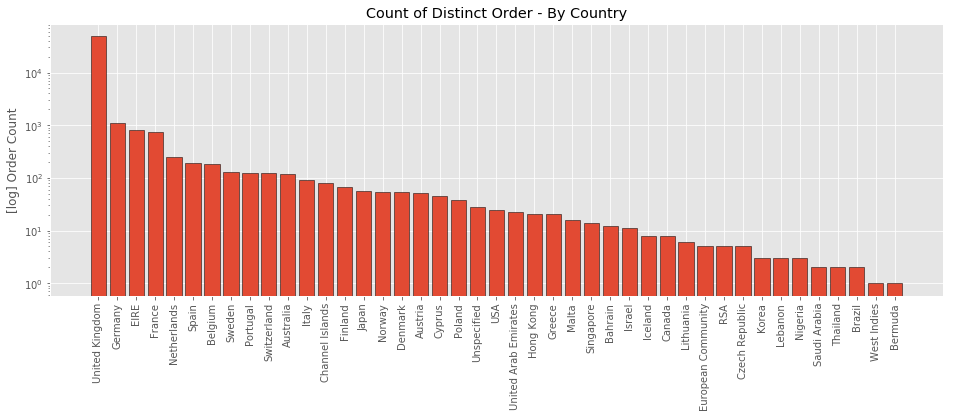

In [123]:
''' plot of Order Count by Country '''
plt.style.use('ggplot')
df_ords_Country = df_ords_Country.sort_values(['Order Count'], axis=0, ascending=False)
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
ax.set_title('Count of Distinct Order - By Country')
ax.set_ylabel('[log] Order Count')
ax.bar(df_ords_Country.index,df_ords_Country['Order Count'],edgecolor='black')
plt.yscale('log')
plt.xticks(rotation = 90);

### Identify Top 5 countries for rule mining

In [125]:
df_ords_Country = df_ords_Country.sort_values(by=['Order Count'], axis=0, ascending=False)
top_countries = df_ords_Country.index[:5]

In [126]:
min_sup_df = pd.DataFrame()

In [78]:
rules_cnt_dict = {}
for locale in top_countries:
    if locale not in min_sup_df.columns and locale not in rules_cnt_dict.keys():
        print locale
        #rules_cnt = mine_rules(locale)
        rules_cnt_dict[locale] = mine_rules(locale)

United Kingdom
len of basket:  37518
Germany
len of basket:  789
EIRE
len of basket:  626
France
len of basket:  622
Netherlands
len of basket:  229


In [79]:
for i in rules_cnt_dict:
    tmp_df = pd.DataFrame.from_dict(rules_cnt_dict[i],orient='index',columns=[i]).sort_values(i,axis=0,
                                                                                              ascending = False)
    #print tmp_df
    min_sup_df[i] = tmp_df[i]

print min_sup_df.head()
''' write to csv '''
min_sup_df.to_csv('../results/freq_item_count.csv')

          United Kingdom  EIRE  Netherlands  Germany  France
0.020000             249   612        13874      501     878
0.031471              71   203          922      167     268
0.042941              31    99          364       80     126
0.054412              10    41          150       41      76
0.065882               5    20           67       24      50


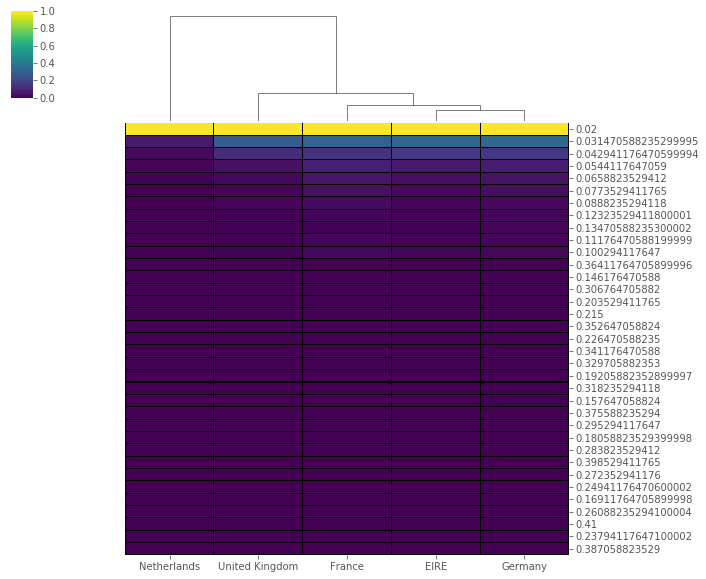

In [144]:
''' plot of freq items by min supp '''
min_sup_df = pd.read_csv('../results/freq_item_count.csv', index_col=0)
sns.clustermap(min_sup_df,standard_scale=1, row_cluster=False, cmap = 'viridis', 
               linewidth=0.005, linecolor='black');

### Loop through 3 countries, finding rules

In [146]:
''' read in min supp thresholds '''
sens_df = pd.read_csv(os.path.join(os.getcwd(),'..','results','freq_item_count.csv'))

In [147]:
countries = []
for doc in os.listdir(os.path.join(os.getcwd(),'../results/rules')):
    countries.append(doc.split('_')[0])

In [89]:
rules = {}
rules_path = os.path.join(os.getcwd(),'../results/rules/')
min_sup = 0.025
for locale in top_countries:
    if locale not in countries and locale not in skip:
        print locale
        file_name = '{}_minsup{}_rules.csv'.format(locale,min_sup)
        rules_gen = mine_rules(locale, min_supp=min_sup).sort_values('confidence', ascending=False)
        if len(rules_gen) > 0:
            rules[locale] = rules_gen
        

        print "Writing {} rules to {}".format(locale,os.path.join(rules_path,file_name))
        rules_export = pd.DataFrame.from_dict(rules_gen)#, orient='index')
        rules_export.to_csv(os.path.join(rules_path,file_name))

United Kingdom
len of basket:  37518
Writing United Kingdom rules to /Users/areichel/Documents/Personals/DS5230/DS5500_ChangeMining/notebooks/../results/rules/United Kingdom_minsup0.025_rules.csv
Germany
len of basket:  789
Writing Germany rules to /Users/areichel/Documents/Personals/DS5230/DS5500_ChangeMining/notebooks/../results/rules/Germany_minsup0.025_rules.csv
EIRE
len of basket:  626
Writing EIRE rules to /Users/areichel/Documents/Personals/DS5230/DS5500_ChangeMining/notebooks/../results/rules/EIRE_minsup0.025_rules.csv
France
len of basket:  622
Writing France rules to /Users/areichel/Documents/Personals/DS5230/DS5500_ChangeMining/notebooks/../results/rules/France_minsup0.025_rules.csv
Netherlands
len of basket:  229
Writing Netherlands rules to /Users/areichel/Documents/Personals/DS5230/DS5500_ChangeMining/notebooks/../results/rules/Netherlands_minsup0.025_rules.csv


In [85]:
mine_rules('United Kingdom', min_supp=0.05/2)

len of basket:  37518


antecedants                           consequents  \
0     (SWEETHEART CERAMIC TRINKET BOX)      (STRAWBERRY CERAMIC TRINKET BOX)   
1     (STRAWBERRY CERAMIC TRINKET BOX)      (SWEETHEART CERAMIC TRINKET BOX)   
2   (RED HANGING HEART T-LIGHT HOLDER)  (WHITE HANGING HEART T-LIGHT HOLDER)   
3              (HEART OF WICKER SMALL)               (HEART OF WICKER LARGE)   
4              (HEART OF WICKER LARGE)               (HEART OF WICKER SMALL)   
5  (JUMBO SHOPPER VINTAGE RED PAISLEY)             (JUMBO BAG RED RETROSPOT)   
6  (WOODEN PICTURE FRAME WHITE FINISH)          (WOODEN FRAME ANTIQUE WHITE)   
7         (WOODEN FRAME ANTIQUE WHITE)   (WOODEN PICTURE FRAME WHITE FINISH)   
8             (JUMBO STORAGE BAG SUKI)             (JUMBO BAG RED RETROSPOT)   

   antecedent support  consequent support   support  confidence       lift  \
0            0.037529            0.057279  0.026414    0.703835  12.287804   
1            0.057279            0.037529  0.026414    0.461145  12.287804   
2            0.044592            0.140093  0.031318    0.702331   5.013329   
3            0.056026            0.051549  0.026387    0.470980   9.136623   
4            0.051549            0.056026  0.026387    0.511892   9.136623   
5            0.056186            0.081294  0.025988    0.462524   5.689497   
6            0.052082            0.053308  0.029053    0.557830  10.464335   
7            0.053308            0.052082  0.029053    0.545000  10.464335   
8            0.059411            0.081294  0.028200    0.474652   5.838690   

   leverage  conviction  
0  0.024264    3.183096  
1  0.024264    1.786141  
2  0.025071    2.888805  
3  0.023499    1.792846  
4  0.023499    1.933946  
5  0.021420    1.709295  
6  0.026276    2.141015  
7  0.026276    2.083337  
8  0.023370    1.748757

### Rules Comparison

In [248]:
''' read in rules of top countries '''
rules_dir = os.path.join(os.getcwd(),'..','results','rules')

''' write top 10 rules by Country to df '''
top_rules = pd.DataFrame()
for i in os.listdir(rules_dir):
    print i.split('_')[0]
    df = pd.read_csv(os.path.join(rules_dir,i),index_col=0).reset_index(drop=True)
    df = df.sort_values(['confidence','support'],axis=0, ascending=False)
    df_top = df.iloc[:,:]
    df_top['country'] = i.split('_')[0]
    top_rules = pd.concat([top_rules, df_top])
top_rules.reset_index(drop=1).sort_values(['support'],axis=0, ascending=False).iloc[:5]

Germany
France
EIRE
United Kingdom
Netherlands


antecedants  \
5101                frozenset(['DOLLY GIRL LUNCH BOX'])   
8923                  frozenset(['SPACEBOY LUNCH BOX'])   
75    frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])   
17     frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS'])   
230          frozenset(['SET/6 RED SPOTTY PAPER CUPS'])   

                                            consequents  antecedent support  \
5101                  frozenset(['SPACEBOY LUNCH BOX'])            0.183406   
8923                frozenset(['DOLLY GIRL LUNCH BOX'])            0.205240   
75     frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS'])            0.262357   
17    frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])            0.169835   
230        frozenset(['SET/6 RED SPOTTY PAPER PLATES'])            0.136656   

      consequent support   support  confidence      lift  leverage  \
5101            0.205240  0.165939    0.904762  4.408308  0.128297   
8923            0.183406  0.165939    0.808511  4.408308  0.128297   
75              0.169835  0.136882    0.521739  3.072031  0.092325   
17              0.262357  0.136882    0.805970  3.072031  0.092325   
230             0.125402  0.114148    0.835294  6.660935  0.097011   

      conviction      country  
5101    8.344978  Netherlands  
8923    4.264435  Netherlands  
75      1.735799      Germany  
17      3.801696      Germany  
230     5.310060       France

In [249]:
''' dict of antecedant count '''
ant_dict = {}
for i in top_rules.antecedants.unique():
    ant_dict[i] = 0

for i in top_rules.antecedants:
    ant_dict[i] += 1
    
''' identify top items '''
for i in ant_dict:
    if ant_dict[i] > 1:
        print i

frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', '5 HOOK HANGER RED MAGIC TOADSTOOL', 'ROUND SNACK BOXES SET OF 4 FRUITS'])
frozenset(['DOLLY GIRL LUNCH BOX', 'LUNCH BAG SPACEBOY DESIGN'])
frozenset(['WOODLAND CHARLOTTE BAG', 'DOLLY GIRL LUNCH BOX', 'PLASTERS IN TIN WOODLAND ANIMALS', 'SPACEBOY LUNCH BOX'])
frozenset(['WOODLAND CHARLOTTE BAG', 'PLASTERS IN TIN SPACEBOY', 'ROUND SNACK BOXES SET OF 4 FRUITS'])
frozenset(['LUNCH BAG WOODLAND', 'CARD DOLLY GIRL'])
frozenset(['PLASTERS IN TIN SPACEBOY', 'PLASTERS IN TIN VINTAGE PAISLEY', 'SPACEBOY LUNCH BOX'])
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'PLASTERS IN TIN WOODLAND ANIMALS', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
frozenset(['PLASTERS IN TIN SPACEBOY', 'ROUND SNACK BOXES SET OF4 WOODLAND', 'ROUND SNACK BOXES SET OF 4 FRUITS', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS', 'JUMBO BAG RED RETROSPOT', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
frozenset(['PLASTERS IN TIN CIRCUS PARADE', 'SKULL LUNC

frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'ROUND SNACK BOXES SET OF4 WOODLAND', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'SKULL LUNCH BOX WITH CUTLERY', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'PLASTERS IN TIN SPACEBOY'])
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'LUNCH BOX WITH CUTLERY RETROSPOT', '72 SWEETHEART FAIRY CAKE CASES'])
frozenset(['PLASTERS IN TIN CIRCUS PARADE', 'SKULL LUNCH BOX WITH CUTLERY', 'PLASTERS IN TIN SPACEBOY'])
frozenset(['REGENCY TEA PLATE GREEN'])
frozenset(['WOODLAND CHARLOTTE BAG', 'DOLLY GIRL LUNCH BOX', 'PLASTERS IN TIN WOODLAND ANIMALS'])
frozenset(['DOLLY GIRL LUNCH BOX', 'RED RETROSPOT CHARLOTTE BAG', 'PLASTERS IN TIN VINTAGE PAISLEY'])
frozenset(['PACK OF 72 RETROSPOT CAKE CASES', 'JUMBO BAG RED RETROSPOT'])
frozenset(['WOODLAND CHARLOTTE BAG', 'DOLLY GIRL LUNCH BOX', 'PLASTERS IN TIN SPACEBOY'])
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'WOODLAND CHARLOTTE BAG', 'LUNCH BOX WITH CUTLERY RETROSPOT'])
froz

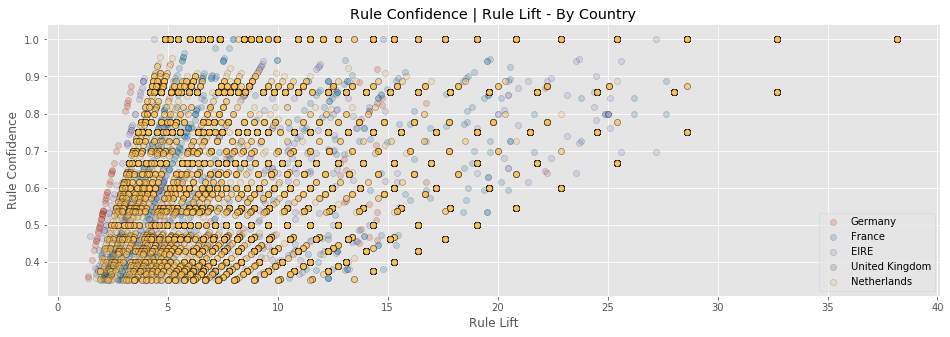

In [268]:
fig = plt.figure(figsize=(16,5*1))
ax = fig.add_subplot(111)

for count,country in enumerate(top_rules.country.unique()):
    
    tmp = top_rules[top_rules.country == country]
    ax.scatter(tmp.lift,tmp.confidence, edgecolors='black', alpha=.25)
    ax.set_xlabel('Rule Lift')
    ax.set_ylabel('Rule Confidence')
ax.set_title('Rule Confidence | Rule Lift - By Country')
plt.legend(top_rules.country.unique())

In [252]:
def frzn_to_list(frznst):
    return frznst.split("(")[1].split(")")[0]

In [253]:
tmp = []
for i in top_rules.antecedants:
    tmp.append(frzn_to_list(i))
top_rules.antecedants = tmp
tmp = []
for i in top_rules.consequents:
    tmp.append(frzn_to_list(i))
top_rules.consequents = tmp

In [243]:
for i in top_rules.consequents:
    print i
    print i.split("(")[1].split(")")[0]

frozenset(['COFFEE MUG APPLES DESIGN'])
['COFFEE MUG APPLES DESIGN']
frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS'])
['ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['STRAWBERRY CERAMIC TRINKET BOX'])
['STRAWBERRY CERAMIC TRINKET BOX']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])
['ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['RED SPOTTY BOWL'])
['RED SPOTTY BOWL']
frozenset(['WOODLAND CHARLOTTE BAG'])
['WOODLAND CHARLOTTE BAG']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])
['ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['WOODLAND CHARLOTTE BAG'])
['WOODLAND CHARLOTTE BAG']
frozenset(['SET/6 RED SPOTTY PAPER PLATES'])
['SET/6 RED SPOTTY PAPER PLATES']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])
['ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])
['ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['RED SPOTTY CUP'])
['RED SPOTTY CUP']
frozenset(['RED STRIPE CERAMIC DRAWER KNOB'])
['RED STRIPE CERAMIC DRAWER KNOB']
frozenset(['SET/6

['REGENCY CAKESTAND 3 TIER', 'REGENCY SUGAR BOWL GREEN']
frozenset(['REGENCY MILK JUG PINK'])
['REGENCY MILK JUG PINK']
frozenset(['60 TEATIME FAIRY CAKE CASES', 'PACK OF 60 PINK PAISLEY CAKE CASES'])
['60 TEATIME FAIRY CAKE CASES', 'PACK OF 60 PINK PAISLEY CAKE CASES']
frozenset(['REGENCY SUGAR BOWL GREEN'])
['REGENCY SUGAR BOWL GREEN']
frozenset(['REGENCY SUGAR BOWL GREEN', 'ROSES REGENCY TEACUP AND SAUCER'])
['REGENCY SUGAR BOWL GREEN', 'ROSES REGENCY TEACUP AND SAUCER']
frozenset(['72 SWEETHEART FAIRY CAKE CASES'])
['72 SWEETHEART FAIRY CAKE CASES']
frozenset(['STRAWBERRY CERAMIC TRINKET BOX'])
['STRAWBERRY CERAMIC TRINKET BOX']
frozenset(['WHITE HANGING HEART T-LIGHT HOLDER'])
['WHITE HANGING HEART T-LIGHT HOLDER']
frozenset(['WOODEN FRAME ANTIQUE WHITE'])
['WOODEN FRAME ANTIQUE WHITE']
frozenset(['WOODEN PICTURE FRAME WHITE FINISH'])
['WOODEN PICTURE FRAME WHITE FINISH']
frozenset(['HEART OF WICKER SMALL'])
['HEART OF WICKER SMALL']
frozenset(['JUMBO BAG RED RETROSPOT'])
['JUMBO 

frozenset(['PLASTERS IN TIN SPACEBOY'])
['PLASTERS IN TIN SPACEBOY']
frozenset(['PLASTERS IN TIN SPACEBOY'])
['PLASTERS IN TIN SPACEBOY']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])
['ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS'])
['ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['SPACEBOY LUNCH BOX'])
['SPACEBOY LUNCH BOX']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY']
frozenset(['DOLLY GIRL LUNCH BOX'])
['DOLLY GIRL LUNCH BOX']
frozenset(['MEMO BOARD COTTAGE DESIGN'])
['MEMO BOARD COTTAGE DESIGN']
frozenset(['SPACEBOY BIRTHDAY CARD'])
['SPACEBOY BIRTHDAY CARD']
frozenset(['SPACEBOY BIRTHDAY CARD'])
['SPACEBOY BIRTHDAY CARD']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])
['ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['PLASTERS IN TIN SPACEBOY'])
['PLASTERS IN TIN SPACEBOY']
frozenset(['DOLLY GIRL LUNCH BOX'])
['DOLLY GIRL LUNCH BOX']
fro

frozenset(['LUNCH BOX WITH CUTLERY RETROSPOT'])
['LUNCH BOX WITH CUTLERY RETROSPOT']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'FOOD CONTAINER SET 3 LOVE HEART'])
['RED TOADSTOOL LED NIGHT LIGHT', 'FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['JUMBO BAG RED RETROSPOT'])
['JUMBO BAG RED RETROSPOT']
frozenset(['LUNCH BOX WITH CUTLERY RETROSPOT'])
['LUNCH BOX WITH CUTLERY RETROSPOT']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT'])
['RED TOADSTOOL LED NIGHT LIGHT']
frozenset(['STRAWBERRY LUNCH BOX WITH CUTLERY'])
['STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['FOOD CONTAINER SET 3 LOVE HEART'])
['FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['PLASTERS IN TIN SPACEBOY'])
['PLASTERS IN TIN SPACEBOY']
frozenset(['PLASTERS IN TIN WOODLAND ANIMALS'])
['PLASTERS IN TIN WOODLAND ANIMALS']
frozenset(['SKULL LUNCH BOX WITH CUTLERY'])
['SKULL LUNCH BOX WITH CUTLERY']
frozenset(['DOLLY GIRL LUNCH BOX', 'FOOD CONTAINER SET 3 LOVE HEART'])
['DOLLY GIRL LUNCH BOX', 'FOOD CONTAINER SET 3 LOVE HEART']
fro

['LUNCH BOX WITH CUTLERY RETROSPOT', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'FOOD CONTAINER SET 3 LOVE HEART'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['DOLLY GIRL LUNCH BOX'])
['DOLLY GIRL LUNCH BOX']
frozenset(['SPACEBOY LUNCH BOX'])
['SPACEBOY LUNCH BOX']
frozenset(['RED LOVE HEART SHAPE CUP'])
['RED LOVE HEART SHAPE CUP']
frozenset(['DOLLY GIRL LUNCH BOX', 'FOOD CONTAINER SET 3 LOVE HEART'])
['DOLLY GIRL LUNCH BOX', 'FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF4 WOODLAND'])
['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['PLASTERS IN TIN WOODLAND ANIMALS'])
['PLASTERS IN TIN WOODLAND ANIMALS']
frozenset(['STRAWBERRY LUNCH BOX WITH CUTLERY'])
['STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF4 WOODLAND', 'FOOD CONTAINER SET 3 LOVE HEART'])
['DOLLY GIRL LUNCH BOX', 'ROUND

['FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['LUNCH BOX WITH CUTLERY RETROSPOT'])
['LUNCH BOX WITH CUTLERY RETROSPOT']
frozenset(['DOLLY GIRL LUNCH BOX'])
['DOLLY GIRL LUNCH BOX']
frozenset(['FOOD CONTAINER SET 3 LOVE HEART'])
['FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'ROUND SNACK BOXES SET OF 4 FRUITS', 'FOOD CONTAINER SET 3 LOVE HEART'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'ROUND SNACK BOXES SET OF 4 FRUITS', 'FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF4 WOODLAND', 'ROUND SNACK BOXES SET OF 4 FRUITS', 'FOOD CONTAINER SET 3 LOVE HEART'])
['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF4 WOODLAND', 'ROUND SNACK BOXES SET OF 4 FRUITS', 'FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS', '72 SWEETHEART FAIRY CAKE CASES'])
['ROUND SNACK BOXES SET OF 4 FRUITS', '72 SWEETHEART FAIRY CAKE CASES']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'JUMBO BAG RED RE

frozenset(['LUNCH BOX WITH CUTLERY RETROSPOT'])
['LUNCH BOX WITH CUTLERY RETROSPOT']
frozenset(['DOLLY GIRL LUNCH BOX', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['DOLLY GIRL LUNCH BOX', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT'])
['RED TOADSTOOL LED NIGHT LIGHT']
frozenset(['PLASTERS IN TIN SPACEBOY'])
['PLASTERS IN TIN SPACEBOY']
frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS', 'JUMBO BAG RED RETROSPOT'])
['ROUND SNACK BOXES SET OF 4 FRUITS', 'JUMBO BAG RED RETROSPOT']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'ROUND SNACK BOXES SET OF 4 FRUITS'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])
['ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])
['ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])
['ROUND SNACK BOXES SET OF4 

frozenset(['DOLLY GIRL LUNCH BOX'])
['DOLLY GIRL LUNCH BOX']
frozenset(['CHARLOTTE BAG DOLLY GIRL DESIGN'])
['CHARLOTTE BAG DOLLY GIRL DESIGN']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])
['ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS'])
['ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['SPACEBOY LUNCH BOX', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['SPACEBOY LUNCH BOX', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS'])
['ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['PLASTERS IN TIN SPACEBOY'])
['PLASTERS IN TIN SPACEBOY']
frozenset(['STRAWBERRY LUNCH BOX WITH CUTLERY'])
['STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['FOOD CONTAINER SET 3 LOVE HEART'])
['FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT'])
['RED TOADSTOOL LED NIGHT LIGHT']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])
['ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['LUNCH BOX WITH CUTLERY RETROSPOT'])
['LUNCH

['RED TOADSTOOL LED NIGHT LIGHT', 'PLASTERS IN TIN SPACEBOY', 'FOOD CONTAINER SET 3 LOVE HEART', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['FOOD CONTAINER SET 3 LOVE HEART', 'CHARLOTTE BAG DOLLY GIRL DESIGN'])
['FOOD CONTAINER SET 3 LOVE HEART', 'CHARLOTTE BAG DOLLY GIRL DESIGN']
frozenset(['PLASTERS IN TIN SPACEBOY'])
['PLASTERS IN TIN SPACEBOY']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'ROUND SNACK BOXES SET OF 4 FRUITS', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'ROUND SNACK BOXES SET OF 4 FRUITS', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'SPACEBOY LUNCH BOX'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'SPACEBOY LUNCH BOX']
frozenset(['SPACEBOY BIRTHDAY CARD', 'SPACEBOY LUNCH BOX'])
['SPACEBOY BIRTHDAY CARD', 'SPACEBOY LUNCH BOX']
frozenset(['PLASTERS IN TIN WOODLAND ANIMALS', 'SPACEBOY LUNCH BOX'])
['PLASTERS IN TIN WOODLAND ANIMALS', 'SPACEBOY LUNCH BOX']
frozenset(['DOLLY GIRL LUNCH BOX', '

['STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'PLASTERS IN TIN SPACEBOY'])
['RED TOADSTOOL LED NIGHT LIGHT', 'PLASTERS IN TIN SPACEBOY']
frozenset(['JUMBO BAG RED RETROSPOT'])
['JUMBO BAG RED RETROSPOT']
frozenset(['DOLLY GIRL LUNCH BOX'])
['DOLLY GIRL LUNCH BOX']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'WOODLAND CHARLOTTE BAG', 'ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY'])
['RED TOADSTOOL LED NIGHT LIGHT', 'WOODLAND CHARLOTTE BAG', 'ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY']
frozenset(['SKULL LUNCH BOX WITH CUTLERY'])
['SKULL LUNCH BOX WITH CUTLERY']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'ROUND SNACK BOXES SET OF 4 FRUITS', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['ROUND SNACK BO

frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'LUNCH BAG RED RETROSPOT'])
['RED TOADSTOOL LED NIGHT LIGHT', 'LUNCH BAG RED RETROSPOT']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'WOODLAND CHARLOTTE BAG'])
['RED TOADSTOOL LED NIGHT LIGHT', 'WOODLAND CHARLOTTE BAG']
frozenset(['JUMBO BAG RED RETROSPOT'])
['JUMBO BAG RED RETROSPOT']
frozenset(['WOODLAND CHARLOTTE BAG', 'COWBOYS AND INDIANS BIRTHDAY CARD', 'ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY'])
['WOODLAND CHARLOTTE BAG', 'COWBOYS AND INDIANS BIRTHDAY CARD', 'ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY']
frozenset(['COWBOYS AND INDIANS BIRTHDAY CARD'])
['COWBOYS AND INDIANS BIRTHDAY CARD']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])
['ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['JUMBO BAG WOODLAND ANIMALS'])
['JUMBO BAG WOODLAND ANIMALS']
frozenset(['LUNCH BOX WITH CUTLERY RETROSPOT', 'ROUND SNACK BOXES SET OF 4 FRUITS'])
['LUNCH BOX WITH CUTLERY RETROSPOT', 'ROUND SNACK BOXES SET OF 4

frozenset(['PLASTERS IN TIN WOODLAND ANIMALS', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['PLASTERS IN TIN WOODLAND ANIMALS', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['DOLLY GIRL LUNCH BOX'])
['DOLLY GIRL LUNCH BOX']
frozenset(['LUNCH BOX WITH CUTLERY RETROSPOT'])
['LUNCH BOX WITH CUTLERY RETROSPOT']
frozenset(['JUMBO BAG WOODLAND ANIMALS'])
['JUMBO BAG WOODLAND ANIMALS']
frozenset(['LUNCH BAG CARS BLUE'])
['LUNCH BAG CARS BLUE']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'FOOD CONTAINER SET 3 LOVE HEART'])
['RED TOADSTOOL LED NIGHT LIGHT', 'FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['LUNCH BAG RED RETROSPOT', 'CHARLOTTE BAG DOLLY GIRL DESIGN'])
['LUNCH BAG RED RETROSPOT', 'CHARLOTTE BAG DOLLY GIRL DESIGN']
frozenset(['PLASTERS IN TIN SPACEBOY', 'CARD DOLLY GIRL'])
['PLASTERS IN TIN SPACEBOY', 'CARD DOLLY GIRL']
frozenset(['PLASTERS IN TIN SPACEBOY'])
['PLASTERS IN TIN SPACEBOY']
frozenset(['WHITE SPOT RED CERAMIC DRAWER KNOB'])
['WHITE SPOT RED CERAMIC DRAWER KNOB']
frozenset(['

frozenset(['STRAWBERRY LUNCH BOX WITH CUTLERY'])
['STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['LUNCH BOX WITH CUTLERY RETROSPOT', 'ROUND SNACK BOXES SET OF 4 FRUITS'])
['LUNCH BOX WITH CUTLERY RETROSPOT', 'ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])
['ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'ROUND SNACK BOXES SET OF 4 FRUITS'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['REGENCY CAKESTAND 3 TIER'])
['REGENCY CAKESTAND 3 TIER']
frozenset(['SKULL LUNCH BOX WITH CUTLERY'])
['SKULL LUNCH BOX WITH CUTLERY']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])
['ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['DOLLY GIRL LUNCH BOX'])
['DOLLY GIRL LUNCH BOX']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])
['ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS'])
['ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['JUMBO BAG RED RETR

['PLASTERS IN TIN WOODLAND ANIMALS']
frozenset(['SKULL LUNCH BOX WITH CUTLERY', 'PLASTERS IN TIN WOODLAND ANIMALS'])
['SKULL LUNCH BOX WITH CUTLERY', 'PLASTERS IN TIN WOODLAND ANIMALS']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'ROUND SNACK BOXES SET OF 4 FRUITS'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'FOOD CONTAINER SET 3 LOVE HEART'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['WOODLAND CHARLOTTE BAG'])
['WOODLAND CHARLOTTE BAG']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'ROUND SNACK BOXES SET OF 4 FRUITS', 'SPACEBOY LUNCH BOX'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'ROUND SNACK BOXES SET OF 4 FRUITS', 'SPACEBOY LUNCH BOX']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY']
frozenset(['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF 4 FRUITS'])
['

frozenset(['COWBOYS AND INDIANS BIRTHDAY CARD'])
['COWBOYS AND INDIANS BIRTHDAY CARD']
frozenset(['JUMBO BAG RED RETROSPOT'])
['JUMBO BAG RED RETROSPOT']
frozenset(['PLASTERS IN TIN SPACEBOY', 'CARD DOLLY GIRL'])
['PLASTERS IN TIN SPACEBOY', 'CARD DOLLY GIRL']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'PLASTERS IN TIN SPACEBOY'])
['RED TOADSTOOL LED NIGHT LIGHT', 'PLASTERS IN TIN SPACEBOY']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'JUMBO BAG RED RETROSPOT'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'JUMBO BAG RED RETROSPOT']
frozenset(['REGENCY CAKESTAND 3 TIER'])
['REGENCY CAKESTAND 3 TIER']
frozenset(['FOLKART ZINC HEART CHRISTMAS DEC'])
['FOLKART ZINC HEART CHRISTMAS DEC']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])
['ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['FOOD CONTAINER SET 3 LOVE HEART'])
['FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['JUMBO BAG RED RETROSPOT'])
['JUMBO BAG RED RETROSPOT']
frozenset(['SPACEBOY BIRTHDAY CARD', 'ROUND SNACK BOXES SET OF4 WOOD

frozenset(['LUNCH BOX WITH CUTLERY RETROSPOT', 'FOOD CONTAINER SET 3 LOVE HEART'])
['LUNCH BOX WITH CUTLERY RETROSPOT', 'FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['WOODLAND CHARLOTTE BAG', 'ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY'])
['WOODLAND CHARLOTTE BAG', 'ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY']
frozenset(['PLASTERS IN TIN SPACEBOY'])
['PLASTERS IN TIN SPACEBOY']
frozenset(['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF 4 FRUITS'])
['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['SPACEBOY LUNCH BOX'])
['SPACEBOY LUNCH BOX']
frozenset(['JUMBO BAG RED RETROSPOT', 'SPACEBOY LUNCH BOX'])
['JUMBO BAG RED RETROSPOT', 'SPACEBOY LUNCH BOX']
frozenset(['LUNCH BAG WOODLAND'])
['LUNCH

['MEMO BOARD RETROSPOT  DESIGN']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['SPACEBOY LUNCH BOX', 'CARD DOLLY GIRL'])
['SPACEBOY LUNCH BOX', 'CARD DOLLY GIRL']
frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS', 'JUMBO BAG RED RETROSPOT'])
['ROUND SNACK BOXES SET OF 4 FRUITS', 'JUMBO BAG RED RETROSPOT']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['RED TOADSTOOL LED NIGHT LIGHT', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['FOOD CONTAINER SET 3 LOVE HEART'])
['FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['ROUND SNACK B

frozenset(['FOOD CONTAINER SET 3 LOVE HEART'])
['FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['DOLLY GIRL LUNCH BOX'])
['DOLLY GIRL LUNCH BOX']
frozenset(['PLASTERS IN TIN SPACEBOY'])
['PLASTERS IN TIN SPACEBOY']
frozenset(['REGENCY CAKESTAND 3 TIER'])
['REGENCY CAKESTAND 3 TIER']
frozenset(['PLASTERS IN TIN WOODLAND ANIMALS'])
['PLASTERS IN TIN WOODLAND ANIMALS']
frozenset(['PLASTERS IN TIN SPACEBOY'])
['PLASTERS IN TIN SPACEBOY']
frozenset(['PLASTERS IN TIN WOODLAND ANIMALS'])
['PLASTERS IN TIN WOODLAND ANIMALS']
frozenset(['DOLLY GIRL LUNCH BOX'])
['DOLLY GIRL LUNCH BOX']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])
['ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS'])
['ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['HOOK, 3 HANGER ,MAGIC GARDEN'])
['HOOK, 3 HANGER ,MAGIC GARDEN']
frozenset(['LUNCH BOX WITH CUTLERY RETROSPOT', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['LUNCH BOX WITH CUTLERY RETROSPOT', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozen

['WOODLAND CHARLOTTE BAG']
frozenset(['LUNCH BAG WOODLAND'])
['LUNCH BAG WOODLAND']
frozenset(['PLASTERS IN TIN CIRCUS PARADE', 'SKULL LUNCH BOX WITH CUTLERY', 'FOOD CONTAINER SET 3 LOVE HEART'])
['PLASTERS IN TIN CIRCUS PARADE', 'SKULL LUNCH BOX WITH CUTLERY', 'FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'SKULL LUNCH BOX WITH CUTLERY', 'FOOD CONTAINER SET 3 LOVE HEART'])
['RED TOADSTOOL LED NIGHT LIGHT', 'SKULL LUNCH BOX WITH CUTLERY', 'FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['LUNCH BAG PINK POLKADOT'])
['LUNCH BAG PINK POLKADOT']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND'])
['ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['72 SWEETHEART FAIRY CAKE CASES'])
['72 SWEETHEART FAIRY CAKE CASES']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN WOODLAND ANIMALS'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN WOODLAND ANIMALS']
frozenset(['WOODLAND CHARLOTTE BAG', 'JUMBO BAG RED RETROSPOT'])
['WOODLAND CHARLOTTE BAG', 

frozenset(['PLASTERS IN TIN CIRCUS PARADE', 'ROUND SNACK BOXES SET OF 4 FRUITS'])
['PLASTERS IN TIN CIRCUS PARADE', 'ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['HEART IVORY TRELLIS LARGE', 'FOLKART ZINC HEART CHRISTMAS DEC'])
['HEART IVORY TRELLIS LARGE', 'FOLKART ZINC HEART CHRISTMAS DEC']
frozenset(['72 SWEETHEART FAIRY CAKE CASES'])
['72 SWEETHEART FAIRY CAKE CASES']
frozenset(['WOODLAND CHARLOTTE BAG', 'LUNCH BAG CARS BLUE'])
['WOODLAND CHARLOTTE BAG', 'LUNCH BAG CARS BLUE']
frozenset(['CHARLOTTE BAG DOLLY GIRL DESIGN'])
['CHARLOTTE BAG DOLLY GIRL DESIGN']
frozenset(['LUNCH BAG WOODLAND'])
['LUNCH BAG WOODLAND']
frozenset(['SPACEBOY LUNCH BOX', '72 SWEETHEART FAIRY CAKE CASES'])
['SPACEBOY LUNCH BOX', '72 SWEETHEART FAIRY CAKE CASES']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY']
frozenset(['PACK OF 60 SPACEBOY CAKE CASES'])
['PACK OF 60 SPACEBOY CAKE CASES']
frozenset(['DOLLY GIR

['ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY']
frozenset(['LUNCH BOX WITH CUTLERY RETROSPOT', 'FOOD CONTAINER SET 3 LOVE HEART'])
['LUNCH BOX WITH CUTLERY RETROSPOT', 'FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['SPACEBOY BIRTHDAY CARD', 'SPACEBOY LUNCH BOX'])
['SPACEBOY BIRTHDAY CARD', 'SPACEBOY LUNCH BOX']
frozenset(['REGENCY CAKESTAND 3 TIER'])
['REGENCY CAKESTAND 3 TIER']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'JUMBO BAG RED RETROSPOT'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'JUMBO BAG RED RETROSPOT']
frozenset(['LUNCH BAG WOODLAND'])
['LUNCH BAG WOODLAND']
frozenset(['WOODLAND CHARLOTTE BAG', 'SPACEBOY LUNCH BOX'])
['WOODLAND CHARLOTTE BAG', 'SPACEBOY LUNCH BOX']
frozenset(['PLASTERS IN TIN SPACEBOY'])
['PLASTERS IN TIN SPACEBOY']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'SPACEBOY LUNCH BOX'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'SPACEBOY LUNCH BOX']
frozenset(['STRAWBERRY LUNCH BOX WITH CUTLERY'])
['STRAWBERRY LUNCH BOX WITH CUTLERY']
fr

['MEMO BOARD COTTAGE DESIGN', 'FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['FOOD CONTAINER SET 3 LOVE HEART'])
['FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['FOOD CONTAINER SET 3 LOVE HEART', 'SPACEBOY LUNCH BOX'])
['FOOD CONTAINER SET 3 LOVE HEART', 'SPACEBOY LUNCH BOX']
frozenset(['RED RETROSPOT CHARLOTTE BAG'])
['RED RETROSPOT CHARLOTTE BAG']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'PLASTERS IN TIN WOODLAND ANIMALS', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'FOOD CONTAINER SET 3 LOVE HEART'])
['RED TOADSTOOL LED NIGHT LIGHT', 'PLASTERS IN TIN WOODLAND ANIMALS', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['SPACEBOY LUNCH BOX'])
['SPACEBOY LUNCH BOX']
frozenset(['REGENCY CAKESTAND 3 TIER', 'FOOD CONTAINER SET 3 LOVE HEART'])
['REGENCY CAKESTAND 3 TIER', 'FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['LUNCH BAG DOLLY GIRL DESIGN'])
['LUNCH BAG DOLLY GIRL DESIGN']
frozenset(['REGENCY CAKESTAND 3 TIER', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['REGENCY

['PLASTERS IN TIN CIRCUS PARADE', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'PLASTERS IN TIN SPACEBOY', 'FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'PLASTERS IN TIN CIRCUS PARADE', 'PLASTERS IN TIN SPACEBOY'])
['RED TOADSTOOL LED NIGHT LIGHT', 'PLASTERS IN TIN CIRCUS PARADE', 'PLASTERS IN TIN SPACEBOY']
frozenset(['DOLLY GIRL LUNCH BOX', 'SPACEBOY LUNCH BOX'])
['DOLLY GIRL LUNCH BOX', 'SPACEBOY LUNCH BOX']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'PLASTERS IN TIN CIRCUS PARADE', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'PLASTERS IN TIN SPACEBOY'])
['RED TOADSTOOL LED NIGHT LIGHT', 'PLASTERS IN TIN CIRCUS PARADE', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'PLASTERS IN TIN SPACEBOY']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT'])
['RED TOADSTOOL LED NIGHT LIGHT']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'REGENCY CAKESTAND 3 TIER'])
['RED TOADSTOOL LED NIGHT LIGHT', 'REGENCY CAKESTAND 3 TIER']
frozenset(['REGENCY CAKESTAND 3 TIER'])
['REGENCY CAKESTAND 3 TIER']
froze

frozenset(['DOLLY GIRL LUNCH BOX'])
['DOLLY GIRL LUNCH BOX']
frozenset(['SKULL LUNCH BOX WITH CUTLERY'])
['SKULL LUNCH BOX WITH CUTLERY']
frozenset(['JUMBO BAG WOODLAND ANIMALS', 'PLASTERS IN TIN WOODLAND ANIMALS'])
['JUMBO BAG WOODLAND ANIMALS', 'PLASTERS IN TIN WOODLAND ANIMALS']
frozenset(['LUNCH BAG SPACEBOY DESIGN'])
['LUNCH BAG SPACEBOY DESIGN']
frozenset(['JUMBO BAG WOODLAND ANIMALS', 'PLASTERS IN TIN SPACEBOY'])
['JUMBO BAG WOODLAND ANIMALS', 'PLASTERS IN TIN SPACEBOY']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT'])
['RED TOADSTOOL LED NIGHT LIGHT']
frozenset(['PLASTERS IN TIN SPACEBOY'])
['PLASTERS IN TIN SPACEBOY']
frozenset(['PLASTERS IN TIN WOODLAND ANIMALS', 'CHARLOTTE BAG DOLLY GIRL DESIGN'])
['PLASTERS IN TIN WOODLAND ANIMALS', 'CHARLOTTE BAG DOLLY GIRL DESIGN']
frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS'])
['ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS'])
['ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['PACK OF 60 MUSHROOM CAKE CAS

frozenset(['REGENCY CAKESTAND 3 TIER', 'DOLLY GIRL LUNCH BOX'])
['REGENCY CAKESTAND 3 TIER', 'DOLLY GIRL LUNCH BOX']
frozenset(['LUNCH BAG WOODLAND', 'JUMBO BAG RED RETROSPOT'])
['LUNCH BAG WOODLAND', 'JUMBO BAG RED RETROSPOT']
frozenset(['FOOD CONTAINER SET 3 LOVE HEART', 'JUMBO BAG RED RETROSPOT'])
['FOOD CONTAINER SET 3 LOVE HEART', 'JUMBO BAG RED RETROSPOT']
frozenset(['PLASTERS IN TIN WOODLAND ANIMALS', 'FOOD CONTAINER SET 3 LOVE HEART'])
['PLASTERS IN TIN WOODLAND ANIMALS', 'FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'COWBOYS AND INDIANS BIRTHDAY CARD', 'PLASTERS IN TIN SPACEBOY'])
['RED TOADSTOOL LED NIGHT LIGHT', 'COWBOYS AND INDIANS BIRTHDAY CARD', 'PLASTERS IN TIN SPACEBOY']
frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS'])
['ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['LUNCH BAG WOODLAND'])
['LUNCH BAG WOODLAND']
frozenset(['PLASTERS IN TIN SPACEBOY', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['PLASTERS IN TIN SPACEBOY', 'STRAWBERRY LUNCH BOX

['PLASTERS IN TIN WOODLAND ANIMALS', 'CLOTHES PEGS RETROSPOT PACK 24']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY']
frozenset(['PACK OF 60 DINOSAUR CAKE CASES', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['PACK OF 60 DINOSAUR CAKE CASES', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'LUNCH BAG WOODLAND'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'LUNCH BAG WOODLAND']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'PLASTERS IN TIN SPACEBOY'])
['RED TOADSTOOL LED NIGHT LIGHT', 'PLASTERS IN TIN SPACEBOY']
frozenset(['COWBOYS AND INDIANS BIRTHDAY CARD', 'FOOD CONTAINER SET 3 LOVE HEART', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['COWBOYS AND INDIANS BIRTHDAY CARD', 'FOOD CONTAINER SET 3 LOVE HEART', 'STRAWBERRY LUNCH BOX 

frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS'])
['ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['ROUND SNACK BOXES SET OF 4 FRUITS', 'SPACEBOY LUNCH BOX'])
['ROUND SNACK BOXES SET OF 4 FRUITS', 'SPACEBOY LUNCH BOX']
frozenset(['RED SPOTTY CHARLOTTE BAG'])
['RED SPOTTY CHARLOTTE BAG']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'MEMO BOARD COTTAGE DESIGN'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'MEMO BOARD COTTAGE DESIGN']
frozenset(['LUNCH BAG WOODLAND'])
['LUNCH BAG WOODLAND']
frozenset(['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF 4 FRUITS'])
['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF 4 FRUITS'])
['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['SPACEBOY BIRTHDAY CARD', 'PLASTERS IN TIN WOODLAND ANIMALS'])
['SPACEBOY BIRTHDAY CARD', 'PLASTERS IN TIN WOODLAND ANIMALS']
frozenset(['WOODLAND CHARLOTTE BAG'])
['WOODLAND CHARLOTTE BAG']
frozenset(['DOLLY GIRL LUNCH BOX', 'R

['PLASTERS IN TIN SPACEBOY', 'ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['60 CAKE CASES DOLLY GIRL DESIGN'])
['60 CAKE CASES DOLLY GIRL DESIGN']
frozenset(['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF4 WOODLAND'])
['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'WOODLAND CHARLOTTE BAG', 'ROUND SNACK BOXES SET OF4 WOODLAND'])
['RED TOADSTOOL LED NIGHT LIGHT', 'WOODLAND CHARLOTTE BAG', 'ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['PACK OF 60 MUSHROOM CAKE CASES'])
['PACK OF 60 MUSHROOM CAKE CASES']
frozenset(['COWBOYS AND INDIANS BIRTHDAY CARD', 'ROUND SNACK BOXES SET OF4 WOODLAND', 'LUNCH BAG RED RETROSPOT', 'CARD DOLLY GIRL'])
['COWBOYS AND INDIANS BIRTHDAY CARD', 'ROUND SNACK BOXES SET OF4 WOODLAND', 'LUNCH BAG RED RETROSPOT', 'CARD DOLLY GIRL']
frozenset(['WOODLAND CHARLOTTE BAG', 'DOLLY GIRL LUNCH BOX', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['WOODLAND CHARLOTTE BAG', 'DOLLY GIRL LUNCH BOX', 'STRAWBERRY LUNCH BOX

frozenset(['JUMBO BAG RED RETROSPOT', 'FOOD CONTAINER SET 3 LOVE HEART', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['JUMBO BAG RED RETROSPOT', 'FOOD CONTAINER SET 3 LOVE HEART', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['PLASTERS IN TIN CIRCUS PARADE'])
['PLASTERS IN TIN CIRCUS PARADE']
frozenset(['DOLLY GIRL LUNCH BOX', 'SPACEBOY LUNCH BOX'])
['DOLLY GIRL LUNCH BOX', 'SPACEBOY LUNCH BOX']
frozenset(['JUMBO BAG OWLS'])
['JUMBO BAG OWLS']
frozenset(['PLASTERS IN TIN CIRCUS PARADE', 'ROUND SNACK BOXES SET OF4 WOODLAND', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'ROUND SNACK BOXES SET OF 4 FRUITS'])
['PLASTERS IN TIN CIRCUS PARADE', 'ROUND SNACK BOXES SET OF4 WOODLAND', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'ROUND SNACK BOXES SET OF 4 FRUITS']
frozenset(['PLASTERS IN TIN CIRCUS PARADE', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'FOOD CONTAINER SET 3 LOVE HEART'])
['PLASTERS IN TIN CIRCUS PARADE', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['DOLLY GIRL LUNCH BOX',

['ROUND SNACK BOXES SET OF4 WOODLAND', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'ROUND SNACK BOXES SET OF 4 FRUITS', 'SPACEBOY LUNCH BOX']
frozenset(['DOLLY GIRL LUNCH BOX', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'SPACEBOY LUNCH BOX', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['DOLLY GIRL LUNCH BOX', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'SPACEBOY LUNCH BOX', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['LUNCH BAG WOODLAND', 'SPACEBOY LUNCH BOX'])
['LUNCH BAG WOODLAND', 'SPACEBOY LUNCH BOX']
frozenset(['LUNCH BAG WOODLAND'])
['LUNCH BAG WOODLAND']
frozenset(['WOODLAND CHARLOTTE BAG', 'DOLLY GIRL LUNCH BOX', 'SPACEBOY LUNCH BOX'])
['WOODLAND CHARLOTTE BAG', 'DOLLY GIRL LUNCH BOX', 'SPACEBOY LUNCH BOX']
frozenset(['WOODLAND CHARLOTTE BAG'])
['WOODLAND CHARLOTTE BAG']
frozenset(['DOLLY GIRL LUNCH BOX', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'ROUND SNACK BOXES SET OF 4 FRUITS', 'SPACEBOY LUNCH BOX'])
['DOLLY GIRL LUNCH BOX', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'ROUND SNACK BOXES SET OF 4 FRUITS', 'SPACE

frozenset(['WOODLAND CHARLOTTE BAG', 'SPACEBOY BIRTHDAY CARD'])
['WOODLAND CHARLOTTE BAG', 'SPACEBOY BIRTHDAY CARD']
frozenset(['SPACEBOY LUNCH BOX', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['SPACEBOY LUNCH BOX', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['PLASTERS IN TIN WOODLAND ANIMALS', 'SPACEBOY LUNCH BOX'])
['PLASTERS IN TIN WOODLAND ANIMALS', 'SPACEBOY LUNCH BOX']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN VINTAGE PAISLEY'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN VINTAGE PAISLEY']
frozenset(['COWBOYS AND INDIANS BIRTHDAY CARD'])
['COWBOYS AND INDIANS BIRTHDAY CARD']
frozenset(['LUNCH BOX WITH CUTLERY RETROSPOT', 'PLASTERS IN TIN SPACEBOY', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['LUNCH BOX WITH CUTLERY RETROSPOT', 'PLASTERS IN TIN SPACEBOY', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['PLASTERS IN TIN CIRCUS PARADE', 'LUNCH BOX WITH CUTLERY RETROSPOT', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['PLASTERS IN TIN CIRCUS PARADE', 'LUNCH BOX

frozenset(['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF 4 FRUITS', 'SPACEBOY LUNCH BOX'])
['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF 4 FRUITS', 'SPACEBOY LUNCH BOX']
frozenset(['PLASTERS IN TIN SPACEBOY', 'CARD DOLLY GIRL'])
['PLASTERS IN TIN SPACEBOY', 'CARD DOLLY GIRL']
frozenset(['DOLLY GIRL LUNCH BOX', 'SPACEBOY LUNCH BOX', '72 SWEETHEART FAIRY CAKE CASES'])
['DOLLY GIRL LUNCH BOX', 'SPACEBOY LUNCH BOX', '72 SWEETHEART FAIRY CAKE CASES']
frozenset(['REGENCY CAKESTAND 3 TIER', 'WOODLAND CHARLOTTE BAG'])
['REGENCY CAKESTAND 3 TIER', 'WOODLAND CHARLOTTE BAG']
frozenset(['REGENCY CAKESTAND 3 TIER', 'ROUND SNACK BOXES SET OF4 WOODLAND'])
['REGENCY CAKESTAND 3 TIER', 'ROUND SNACK BOXES SET OF4 WOODLAND']
frozenset(['SPACEBOY BIRTHDAY CARD', 'PLASTERS IN TIN WOODLAND ANIMALS'])
['SPACEBOY BIRTHDAY CARD', 'PLASTERS IN TIN WOODLAND ANIMALS']
frozenset(['LUNCH BOX WITH CUTLERY RETROSPOT', 'ROUND SNACK BOXES SET OF 4 FRUITS', '72 SWEETHEART FAIRY CAKE CASES'])
['LUNCH BOX WITH CU

frozenset(['CHARLOTTE BAG PINK POLKADOT'])
['CHARLOTTE BAG PINK POLKADOT']
frozenset(['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF 4 FRUITS', 'SPACEBOY LUNCH BOX', 'JUMBO BAG RED RETROSPOT'])
['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF 4 FRUITS', 'SPACEBOY LUNCH BOX', 'JUMBO BAG RED RETROSPOT']
frozenset(['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY'])
['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTERS IN TIN SPACEBOY']
frozenset(['DOLLY GIRL LUNCH BOX', 'PLASTERS IN TIN SPACEBOY', 'SPACEBOY LUNCH BOX'])
['DOLLY GIRL LUNCH BOX', 'PLASTERS IN TIN SPACEBOY', 'SPACEBOY LUNCH BOX']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', 'PLASTERS IN TIN CIRCUS PARADE'])
['RED TOADSTOOL LED NIGHT LIGHT', 'PLASTERS IN TIN CIRCUS PARADE']
frozenset(['LUNCH BAG WOODLAND'])
['LUNCH BAG WOODLAND']
frozenset(['REGENCY CAKESTAND 3 TIER', 'WOODLAND CHARLOTTE BAG', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['REGENCY CAKESTAND 3 TIER', 'WOO

frozenset(['SPACEBOY BIRTHDAY CARD'])
['SPACEBOY BIRTHDAY CARD']
frozenset(['WOODLAND CHARLOTTE BAG', 'DOLLY GIRL LUNCH BOX', 'SPACEBOY LUNCH BOX'])
['WOODLAND CHARLOTTE BAG', 'DOLLY GIRL LUNCH BOX', 'SPACEBOY LUNCH BOX']
frozenset(['LUNCH BOX WITH CUTLERY RETROSPOT', 'SPACEBOY LUNCH BOX'])
['LUNCH BOX WITH CUTLERY RETROSPOT', 'SPACEBOY LUNCH BOX']
frozenset(['DOLLY GIRL LUNCH BOX', 'FOOD CONTAINER SET 3 LOVE HEART', 'SPACEBOY LUNCH BOX'])
['DOLLY GIRL LUNCH BOX', 'FOOD CONTAINER SET 3 LOVE HEART', 'SPACEBOY LUNCH BOX']
frozenset(['FOOD CONTAINER SET 3 LOVE HEART', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['FOOD CONTAINER SET 3 LOVE HEART', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['LUNCH BOX WITH CUTLERY RETROSPOT'])
['LUNCH BOX WITH CUTLERY RETROSPOT']
frozenset(['LUNCH BAG WOODLAND', 'FOOD CONTAINER SET 3 LOVE HEART'])
['LUNCH BAG WOODLAND', 'FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['WOODLAND CHARLOTTE BAG', 'DOLLY GIRL LUNCH BOX'])
['WOODLAND CHARLOTTE BAG', 'DOLLY GIRL LUNC

['WOODLAND CHARLOTTE BAG', 'DOLLY GIRL LUNCH BOX', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['LUNCH BOX WITH CUTLERY RETROSPOT', 'STRAWBERRY LUNCH BOX WITH CUTLERY'])
['LUNCH BOX WITH CUTLERY RETROSPOT', 'STRAWBERRY LUNCH BOX WITH CUTLERY']
frozenset(['DOLLY GIRL LUNCH BOX', 'CARD DOLLY GIRL'])
['DOLLY GIRL LUNCH BOX', 'CARD DOLLY GIRL']
frozenset(['LUNCH BAG WOODLAND', 'ROUND SNACK BOXES SET OF 4 FRUITS', 'JUMBO BAG RED RETROSPOT'])
['LUNCH BAG WOODLAND', 'ROUND SNACK BOXES SET OF 4 FRUITS', 'JUMBO BAG RED RETROSPOT']
frozenset(['ROUND SNACK BOXES SET OF4 WOODLAND', 'LUNCH BAG RED RETROSPOT', 'FOOD CONTAINER SET 3 LOVE HEART'])
['ROUND SNACK BOXES SET OF4 WOODLAND', 'LUNCH BAG RED RETROSPOT', 'FOOD CONTAINER SET 3 LOVE HEART']
frozenset(['SPACEBOY BIRTHDAY CARD', 'ROUND SNACK BOXES SET OF4 WOODLAND', 'CHARLOTTE BAG DOLLY GIRL DESIGN'])
['SPACEBOY BIRTHDAY CARD', 'ROUND SNACK BOXES SET OF4 WOODLAND', 'CHARLOTTE BAG DOLLY GIRL DESIGN']
frozenset(['RED TOADSTOOL LED NIGHT LIGHT', '

In [263]:
top_rules[['antecedants','consequents','support','confidence',
          'lift','country']].sort_values('support', axis = 0, ascending=False).head()

antecedants  \
4200                ['DOLLY GIRL LUNCH BOX']   
8022                  ['SPACEBOY LUNCH BOX']   
75    ['ROUND SNACK BOXES SET OF4 WOODLAND']   
17     ['ROUND SNACK BOXES SET OF 4 FRUITS']   
86           ['SET/6 RED SPOTTY PAPER CUPS']   

                                 consequents   support  confidence      lift  \
4200                  ['SPACEBOY LUNCH BOX']  0.165939    0.904762  4.408308   
8022                ['DOLLY GIRL LUNCH BOX']  0.165939    0.808511  4.408308   
75     ['ROUND SNACK BOXES SET OF 4 FRUITS']  0.136882    0.521739  3.072031   
17    ['ROUND SNACK BOXES SET OF4 WOODLAND']  0.136882    0.805970  3.072031   
86         ['SET/6 RED SPOTTY PAPER PLATES']  0.114148    0.835294  6.660935   

          country  
4200  Netherlands  
8022  Netherlands  
75        Germany  
17        Germany  
86         France

In [258]:
top_rules

antecedants  \
0                           ['COFFEE MUG PEARS  DESIGN']   
1      ['ROUND SNACK BOXES SET OF4 WOODLAND', 'LUNCH ...   
2                     ['SWEETHEART CERAMIC TRINKET BOX']   
3      ['ROUND SNACK BOXES SET OF 4 FRUITS', 'SPACEBO...   
4                                   ['BLUE SPOTTY BOWL']   
5                        ['RED RETROSPOT CHARLOTTE BAG']   
6      ['LUNCH BOX WITH CUTLERY RETROSPOT', 'ROUND SN...   
7                          ['CHARLOTTE BAG SUKI DESIGN']   
8                        ['SET/6 RED SPOTTY PAPER CUPS']   
9      ['WOODLAND CHARLOTTE BAG', 'ROUND SNACK BOXES ...   
10     ['PLASTERS IN TIN WOODLAND ANIMALS', 'ROUND SN...   
11                                  ['RED SPOTTY PLATE']   
12                   ['BLUE STRIPE CERAMIC DRAWER KNOB']   
13                     ['SET/6 RED SPOTTY PAPER PLATES']   
14     ['PLASTERS IN TIN CIRCUS PARADE', 'ROUND SNACK...   
15                                  ['PINK  SPOTTY CUP']   
16                                   ['RED SPOTTY BOWL']   
17                 ['ROUND SNACK BOXES SET OF 4 FRUITS']   
18                                  ['BLUE  SPOTTY CUP']   
19     ['ROUND SNACK BOXES SET OF4 WOODLAND', 'PLASTE...   
20     ['PLASTERS IN TIN WOODLAND ANIMALS', 'PLASTERS...   
23                         ['PLASTERS IN TIN STRONGMAN']   
21                               ['RED RETROSPOT PLATE']   
22     ['PLASTERS IN TIN SPACEBOY', 'ROUND SNACK BOXE...   
24     ['RED TOADSTOOL LED NIGHT LIGHT', 'ROUND SNACK...   
25                   ['SAVE THE PLANET COTTON TOTE BAG']   
26     ['ROUND SNACK BOXES SET OF4 WOODLAND', 'SAVE T...   
27                      ['RED SPOT CERAMIC DRAWER KNOB']   
28                    ['RED STRIPE CERAMIC DRAWER KNOB']   
30     ['PLASTERS IN TIN CIRCUS PARADE', 'ROUND SNACK...   
...                                                  ...   
25281  ['PLASTERS IN TIN WOODLAND ANIMALS', 'PLASTERS...   
25282                ['CHARLOTTE BAG DOLLY GIRL DESIGN']   
25283                 ['PACK OF 60 SPACEBOY CAKE CASES']   
25284                ['CHARLOTTE BAG DOLLY GIRL DESIGN']   
25285                ['CHARLOTTE BAG DOLLY GIRL DESIGN']   
25286                 ['PACK OF 60 SPACEBOY CAKE CASES']   
25287                 ['CREAM CUPID HEARTS COAT HANGER']   
25288                ['CHARLOTTE BAG DOLLY GIRL DESIGN']   
25289  ['ROUND SNACK BOXES SET OF 4 FRUITS', 'SPACEBO...   
25290  ['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SE...   
25291  ['ROUND SNACK BOXES SET OF 4 FRUITS', 'SPACEBO...   
25292                 ['CREAM CUPID HEARTS COAT HANGER']   
25293  ['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SE...   
25294  ['DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SE...   
25295                 ['PACK OF 60 SPACEBOY CAKE CASES']   
25296                 ['CREAM CUPID HEARTS COAT HANGER']   
25297                ['CHARLOTTE BAG DOLLY GIRL DESIGN']   
25298  ['PLASTERS IN TIN WOODLAND ANIMALS', 'PLASTERS...   
25299                 ['CREAM CUPID HEARTS COAT HANGER']   
25300                ['CHARLOTTE BAG DOLLY GIRL DESIGN']   
25301                 ['PACK OF 60 SPACEBOY CAKE CASES']   
25302  ['PLASTERS IN TIN WOODLAND ANIMALS', 'PLASTERS...   
25303                ['CHARLOTTE BAG DOLLY GIRL DESIGN']   
25304                 ['CREAM CUPID HEARTS COAT HANGER']   
25305                 ['PACK OF 60 SPACEBOY CAKE CASES']   
25306  ['ROUND SNACK BOXES SET OF 4 FRUITS', 'SPACEBO...   
25307                ['CHARLOTTE BAG DOLLY GIRL DESIGN']   
25308                ['CHARLOTTE BAG DOLLY GIRL DESIGN']   
25309  ['PLASTERS IN TIN WOODLAND ANIMALS', 'PLASTERS...   
25310                ['CHARLOTTE BAG DOLLY GIRL DESIGN']   

                                             consequents  antecedent support  \
0                           ['COFFEE MUG APPLES DESIGN']            0.031686   
1                  ['ROUND SNACK BOXES SET OF 4 FRUITS']            0.034221   
2                     ['STRAWBERRY CERAMIC TRINKET BOX']            0.032953   
3   